# Load the data and set the neural network parameters

/!\ Parameters can be changed in this cell, please read the comments. /!\



**The PINEM parameters follow this ordering : g, rt, fwhm, omega, offset**


## Setting the training parameters

In [4]:
# ------------- Relevant paths ---------------------------------
# Paths to the training dataset, the test dataset and the logger
filename = './datasets/pinem_amp100_bkgd0.1_nort_seed42.npz'
test_filename = './datasets/test_model_pinem_amp100_bkgd0.1_nort_seed42.npz'
logger_path = './logs/cnn_3layers_32_v1.json'

# Normalization method : 'normalize' or 'scale' or 'both'. None should be avoided
normalization = 'normalize'

# ------------- Network architecture ----------------------------
# Number of parameters to be learned by the network
n_params = 2
# Loss function of the network : 'normal' of 'poisson
mode = 'normal'
# Network layers : list of integers
layers = [32, 32, 32]
# Kernel sizes : list of integers /!\ must have the same length as layers /!\
kernel_sizes = [3, 3, 3]
# Dropout rates : list of floats /!\ must have the same length as layers /!\
dropout_rates = [0.5, 0.5, 0.5]

## Initialisation of the data and network

In [5]:
import mlpynem.models as m
import mlpynem.dataset as d
import numpy as np
import mlpynem.logger as l

# dummy parameters for the loading of the dataset (They don't matter, it just has to be a list of 5 elements)
_ = [None,None,None,None,None]

dataset = d.DatasetPinem(*_,load = filename)
pipe = m.DataPreprocessor(dataset.noisy_spectres, dataset.xs[:,:-(n_params + 1)],normalization=normalization, convolution=True)

log = l.ModelInfo(logger_path)
log.add_iteration(filename,test_filename)
log.save_norm(normalization)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = pipe.preprocess()

cnn = m.CNNModel(dataset.p.x.shape[0],n_params, mode = mode,filters=layers,kernel_size=kernel_sizes,dropouts=dropout_rates)

log.save_model(cnn)


## Train the network and plot the loss

/!\ It might take a while. If you run the code on a laptop it is time to plug it. /!\

Epoch 1/5
1434/1434 [==============================] - 25s 18ms/step - loss: 0.0235 - mse: 0.0235 - mae: 0.0894 - val_loss: 0.0854 - val_mse: 0.0854 - val_mae: 0.1829
Epoch 2/5
1434/1434 [==============================] - 25s 18ms/step - loss: 0.0228 - mse: 0.0228 - mae: 0.0877 - val_loss: 0.0707 - val_mse: 0.0707 - val_mae: 0.1708
Epoch 3/5
1434/1434 [==============================] - 25s 17ms/step - loss: 0.0221 - mse: 0.0221 - mae: 0.0863 - val_loss: 0.0714 - val_mse: 0.0714 - val_mae: 0.1682
Epoch 4/5
1434/1434 [==============================] - 25s 17ms/step - loss: 0.0214 - mse: 0.0214 - mae: 0.0853 - val_loss: 0.0736 - val_mse: 0.0736 - val_mae: 0.1709
Epoch 5/5
1434/1434 [==============================] - 25s 18ms/step - loss: 0.0207 - mse: 0.0207 - mae: 0.0841 - val_loss: 0.0753 - val_mse: 0.0753 - val_mae: 0.1678


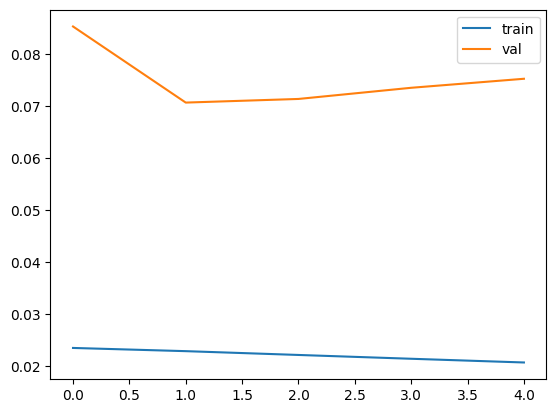

In [7]:
cnn.train(X_train, y_train, X_val, y_val, epochs = 300, batch_size = 32)
cnn.plot_history()

## Test the network

In [11]:
tst = np.load(test_filename)
test_pipe = m.DataPreprocessor(1,2)
X_test = test_pipe.normalize_data(tst['data'])[:,:,np.newaxis]
res = cnn.predict(X_test)

err = res - tst['truth']
mean_err = np.mean(err, axis = 0)
std_err = np.std(err, axis = 0)
err_dict= {'mean_g_err' : mean_err[0], 'std_g_err' : std_err[0], 'mean_rt_err' : mean_err[1], 'std_rt_err' : std_err[1]}

## Save the results

In [8]:
log.save_test_results(err_dict)
log.save()